In [2]:
import pandas as pd
from tqdm import tqdm
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from pathlib import Path
import yaml 
import os

from helpers.linkage import *
from helpers import dataloader
from helpers.afa import adaptive_filter
from helpers.visuals import add_cabinet_periods

cf = yaml.safe_load(Path('config.yml').read_text())

/home/rb/.virtualenvs/phd_venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 218/218 [00:14<00:00, 15.13it/s]


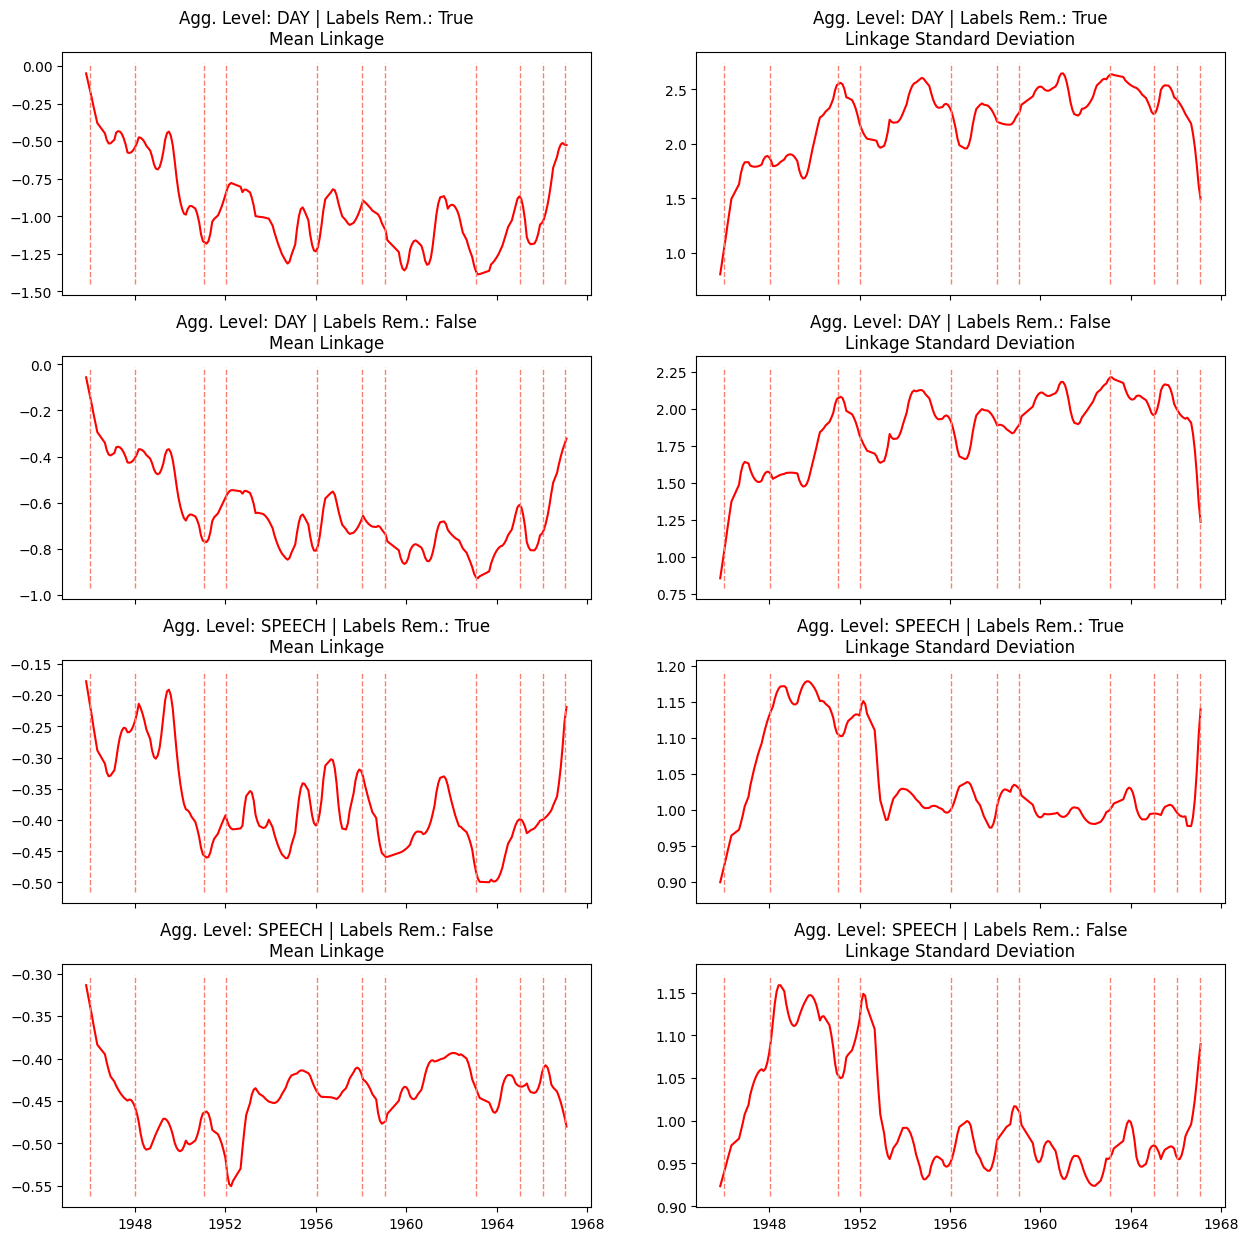

In [6]:
model_options = [("day",['rhet','nonsem','proc']),("day",[]),("speech",['rhet','nonsem','proc']),("speech",[])]

c = 0

fig,axs = plt.subplots(4,2,sharex=True,figsize=(15,15))

for agg_level, remove_labels in model_options:
    data = dataloader.load_lda(cf,agg_level=agg_level,remove_labels=remove_labels)
    dists = data['dists']

    dict_date_theta = {d:_.to_numpy() for d,_ in dists.groupby(dists.index.to_period('M'))}
    stats, mi_arrays = diachronic_linkage(dict_date_theta)
    stats = pd.DataFrame(stats)

    for col in ['mi_mu','mi_sigma']:
        stats[col+'_afa'] = adaptive_filter(stats[col])
    stats['date'] = pd.to_datetime(stats.date.dt.to_timestamp(),infer_datetime_format=True)

    ax = axs.flatten()[c]
    ax.plot(stats.date,stats.mi_mu_afa,color='red')
    ax.set_title(f'Agg. Level: {agg_level.upper()} | Labels Rem.: {"True" if len(remove_labels) > 0 else False}\nMean Linkage',fontsize=12)
    add_cabinet_periods(ax,text=False,alpha=1)
    # ax.vlines(x=[f'{y}-01-01' for y in range(1946,1967)], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', ls='--',alpha=.25, lw=.75)
    ax.grid(True,which='minor')

    ax = axs.flatten()[c+1]
    ax.plot(stats.date,stats.mi_sigma_afa,color='red')
    ax.set_title(f'Agg. Level: {agg_level.upper()} | Labels Rem.: {"True" if len(remove_labels) > 0 else False}\nLinkage Standard Deviation',fontsize=12)
    add_cabinet_periods(ax,text=False,alpha=1) #change path name here
    # ax.vlines(x=[f'{y}-01-01' for y in range(1946,1967)], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='k', ls='--',alpha=.25, lw=.75)
    ax.grid(True,which='minor')

    c += 2
plt.subplots_adjust(hspace=.25)
plt.savefig('figs/lda-linkage-level-label-comparison.pdf')
plt.show()